# pls work

In [1]:
import os

kaggle = False
base_dir = os.getcwd()
print(f"Base directory: {base_dir}")

### UNCOMMENT IF USING KAGGLE/COLAB ###
!pip install librosa pandas 
kaggle = True
data_dir = '/kaggle/input/fma-free-music-archive-small-medium'
###

# !pip install torch==2.6.0 #not needed?

Base directory: /kaggle/working


In [2]:
import pandas as pd
import librosa
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

2.5.1+cu124


In [3]:
import pandas as pd

# import the csv file
directory = data_dir if kaggle else base_dir
file_path = os.path.join(directory, 'fma_metadata', 'tracks.csv')
df_labelconvertion = pd.read_csv(file_path, index_col=1)

# rename columns to actual names
df_labelconvertion.rename(columns={'Unnamed: 0': 'track_id', 'track.7': 'genre_top'}, inplace=True)

# make df of only the important columns
df_labelconvertion = df_labelconvertion[['track_id', 'genre_top']]

# set all NA values to other 
df_labelconvertion['genre_top'] = df_labelconvertion['genre_top'].fillna('Other')

# reset index from albums to normal index
df_labelconvertion = df_labelconvertion.reset_index(drop=True)

# make all values in the track_id column strings
df_labelconvertion['track_id'] = df_labelconvertion['track_id'].astype(str)

# remove first two rows
df_labelconvertion = df_labelconvertion.iloc[2:]


df_labelconvertion


/tmp/ipykernel_31/1240877027.py:6: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df_labelconvertion = pd.read_csv(file_path, index_col=1)


,track_id,genre_top
2,2,Hip-Hop
3,3,Hip-Hop
4,5,Hip-Hop
5,10,Pop
6,20,Other
...,...,...
106571,155316,Rock
106572,155317,Rock
106573,155318,Rock
106574,155319,Rock


In [4]:
# print unique values in the genre_top column
unique_genres = df_labelconvertion['genre_top'].unique()
print(f"Unique genres: {unique_genres}")

Unique genres: ['Hip-Hop' 'Pop' 'Other' 'Rock' 'Experimental' 'Folk' 'Jazz' 'Electronic'
 'Spoken' 'International' 'Soul-RnB' 'Blues' 'Country' 'Classical'
 'Old-Time / Historic' 'Instrumental' 'Easy Listening']


In [5]:
import os

df_labelnumber = pd.DataFrame(columns=['labelnumber', 'unique genres'])
labelnumber = {}
for i, genre in enumerate(unique_genres):
    labelnumber[genre] = i
    
df_labelnumber = pd.DataFrame(labelnumber, index=[0])
# make rows into columns
df_labelnumber = df_labelnumber.transpose()

# save to csv file
os.makedirs("fma_metadata", exist_ok=True)
file_path = os.path.join(base_dir, 'fma_metadata', 'labelnumber.csv')
df_labelnumber.to_csv(file_path, index= True)


In [6]:
df_labelnumbers = pd.read_csv('fma_metadata/labelnumber.csv')

df_labelnumbers.rename(columns={'Unnamed: 0': 'genre', '0': 'number'}, inplace=True)

df_labelnumbers

,genre,number
0,Hip-Hop,0
1,Pop,1
2,Other,2
3,Rock,3
4,Experimental,4
5,Folk,5
6,Jazz,6
7,Electronic,7
8,Spoken,8
9,International,9


In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import torch

class SpectrogramDataset(Dataset):
    def __init__(self, file_paths, sr=44100, n_fft=1024, hop_length=512, window='hann', transform=None):
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.window = window
        self.transform = transform
        self.file_paths = file_paths
                    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        y, sr = librosa.load(file_path, sr=self.sr, mono = True)
        y = y[:10 * self.sr]
        D = librosa.stft(y, n_fft=self.n_fft, hop_length=self.hop_length, window=self.window)
        D_real = np.real(D)
        D_imag = np.imag(D)
        
        # Normalize
        # D_real = (D_real - D_real.min()) / (D_real.max() - D_real.min() + 1e-8) * 2 - 1
        # D_imag = (D_imag - D_imag.min()) / (D_imag.max() - D_imag.min() + 1e-8) * 2 - 1
        D_real_mean = -0.00022800823861055075
        D_real_std = 3.1135954811248605
        D_imag_mean = -2.303626924950437e-08
        D_imag_std = 2.8981973344661305

        D_real = (D_real - D_real_mean) / (16 * (D_real_std + 1e-8))
        D_imag = (D_imag - D_imag_mean) / (16 * (D_imag_std + 1e-8))
        
        D_real = torch.tensor(D_real, dtype=torch.float32)
        D_imag = torch.tensor(D_imag, dtype=torch.float32)
        
        # concat real and imaginary parts to 2 channels
        D = torch.stack((D_real, D_imag), dim=0)
        # Normalize, after stack to normalize both channels equaly
        # D = (D - D.mean()) / (D.std() + 1e-8)
        
        # get the label from the file name and convert to genre
        track_id = os.path.basename(file_path).replace('.mp3', '').lstrip('0')
        # try to get the label from the dataframe
        try:
            # label = df_labelconvertion.query('track_id == @track_id')['genre_top'].values[0]
            label = df_labelconvertion.query('track_id == @track_id')['genre_top'].values[0]
            label = torch.tensor(df_labelnumbers.query('genre == @label')['number'].values[0])
        except IndexError:
            # if not found, set label to 'Other'
            print(f"Track ID: {track_id} not found in dataframe")
            label = 'Other'
        
        return D, label

In [8]:
file_directory = os.path.join(directory, 'fma_small', 'fma_small')

# train test split
from sklearn.model_selection import train_test_split
import soundfile as sf

# get all file paths
file_paths = []
for root, _, files in os.walk(file_directory):
    for file in files:
        if file.endswith('.mp3'):
            file_paths.append(os.path.join(root, file))
            
# split the file paths into train and test
train_paths, test_paths = train_test_split(file_paths, test_size=0.2, random_state=42)

# find if any song is shorter than 10 seconds or is corrupted
min_duration = 10
for path in train_paths:
    try:
        info = sf.info(path)
        duration = info.frames / info.samplerate
        if duration < min_duration:
            print(f"{path} is too short: {duration:.2f}s")
            train_paths.remove(path)
    except Exception as e:
        print(f"File {path} is corrupted: {e}")
        train_paths.remove(path)
        
for path in test_paths:
    try:
        info = sf.info(path)
        duration = info.frames / info.samplerate
        if duration < min_duration:
            print(f"{path} is too short: {duration:.2f}s")
            test_paths.remove(path)
    except Exception as e:
        print(f"File {path} is corrupted: {e}")
        test_paths.remove(path)


/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/098/098565.mp3 is too short: 1.63s
File /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/133/133297.mp3 is corrupted: Error opening '/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/133/133297.mp3': File does not exist or is not a regular file (possibly a pipe?).


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


File /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/099/099134.mp3 is corrupted: Error opening '/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/099/099134.mp3': File does not exist or is not a regular file (possibly a pipe?).


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/098/098567.mp3 is too short: 0.54s
File /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/108/108925.mp3 is corrupted: Error opening '/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/108/108925.mp3': File does not exist or is not a regular file (possibly a pipe?).


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/098/098569.mp3 is too short: 1.56s


In [10]:
# create dataloader
batch_size = 32
num_workers = 4

train_dataset = SpectrogramDataset(train_paths)
test_dataset = SpectrogramDataset(test_paths)

num_workers = num_workers if kaggle else 0
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=kaggle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=kaggle)

In [11]:
# check the shape of the data
# for batch in train_dataloader:
#     print(batch[0].shape)
#     print(batch[0].max(),batch[0].min())
#     print(batch[1].shape)
#     break

In [16]:
import sys
import gc
import shutil

if kaggle:
    sys.path.append('/kaggle/input/cvae-actual-i-think')

import cvae_actual_i_think
import importlib
importlib.reload(cvae_actual_i_think) # Reload the cvae module to ensure it's up to date

#del model, trainer# , logger, best_callback, early_stop_callback #periodic_callback,
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
torch.cuda.reset_peak_memory_stats()

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.utilities.model_summary import summarize




model = cvae_actual_i_think.ConvCVAEPL(latent_size = 128, learning_rate = 1e-3)

# Logger for saving training metrics
logger = CSVLogger("logs", name="cvae_training_metrics")


checkpoint_dir = "checkpoints"

if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

os.makedirs(checkpoint_dir)

# Checkpoint callback to save the best model
periodic_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename="{epoch:02d}-{val_loss:.2f}",
    save_top_k=-1,
    every_n_epochs=5,
    save_weights_only=False,
)

# Checkpoint callback to save the best model
best_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename="Best-{epoch:02d}-{val_loss:.2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_weights_only=False,
)



# Early stopping callback to stop training when validation loss doesn't improve
early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=4)

# Initialize the PyTorch Lightning Trainer
trainer = Trainer(
    max_epochs=10, 
    accelerator="gpu", 
    devices=1, 
    logger=logger, 
    callbacks=[periodic_callback, best_callback, early_stop_callback],
    enable_model_summary = True,
    # accumulate_grad_batches = 2, #one of these two needed with current network
    #precision = "16-mixed",
)

# Train the model
import time
print(model)
print(summarize(model))
start_time = time.time()
print("Training started")

trainer.fit(model, train_dataloader, val_dataloaders=test_dataloader)
print("Training finished")
end_time = time.time()
print(f"Training time: {(end_time - start_time):.3f} seconds")

ConvCVAEPL(
  (model): ConvCVAE(
    (encoder_conv1): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder_conv2): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder_conv3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder_conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder_conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (adaptive_pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (encoder_fc_mu): Linear(in_features=256, out_features=128, bias=True)
    (encoder_fc_logvar): Lin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 0], Beta: 0.1000, Train Loss: 4506.2866, Recon: 4506.2671, KLD: 0.1728 , Val Loss: 3482.8069


[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 1], Beta: 0.1162, Train Loss: 3524.0742, Recon: 3524.0493, KLD: 0.1959 , Val Loss: 3469.5928


[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 2], Beta: 0.1350, Train Loss: 3499.1677, Recon: 3499.1482, KLD: 0.1436 , Val Loss: 3467.3000


[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 3], Beta: 0.1568, Train Loss: 3493.6960, Recon: 3493.6799, KLD: 0.1021 , Val Loss: 3465.9868


[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 4], Beta: 0.1822, Train Loss: 3492.6094, Recon: 3492.5969, KLD: 0.0543 , Val Loss: 3465.8416


[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 5], Beta: 0.2117, Train Loss: 3491.7354, Recon: 3491.7307, KLD: 0.0290 , Val Loss: 3465.6399


[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 6], Beta: 0.2460, Train Loss: 3491.2610, Recon: 3491.1331, KLD: 0.5174 , Val Loss: 3464.7988


[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 7], Beta: 0.2858, Train Loss: 5675.5845, Recon: 4333.3979, KLD: 4696.8115 , Val Loss: 3470.7124


[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 8], Beta: 0.3320, Train Loss: 3494.9351, Recon: 3494.7661, KLD: 0.5055 , Val Loss: 3467.9707


[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 9], Beta: 0.3857, Train Loss: 3493.4028, Recon: 3493.3318, KLD: 0.1845 , Val Loss: 3466.6721
Training finished
Training time: 3444.106 seconds


In [17]:
shutil.make_archive('/kaggle/working/checkpoints_backup', 'zip', '/kaggle/working/checkpoints')

'/kaggle/working/checkpoints_backup.zip'

In [18]:
# Load best model weights after training
best_model_path = best_callback.best_model_path
model = cvae_actual_i_think.ConvCVAEPL.load_from_checkpoint(best_model_path, latent_size = 128, learning_rate = 1e-3)

# Save model weights to a file (PyTorch format)
torch.save(model.state_dict(), "/kaggle/working/best_model_weights_1.pth")

## Plot training data

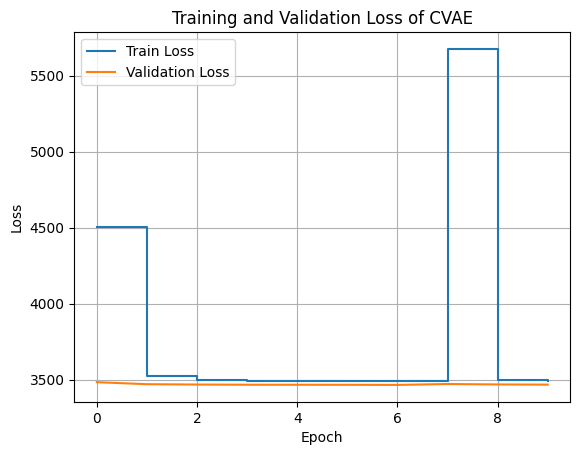

In [19]:
import matplotlib.pyplot as plt

metrics = pd.read_csv(os.path.join(logger.log_dir, "metrics.csv")).ffill()

def plot_training_metrics(metrics):
    """Plot training metrics by epoch."""

    plt.plot(metrics["epoch"], metrics["train_loss"], label="Train Loss")
    plt.plot(metrics["epoch"], metrics["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss of CVAE")
    plt.grid()
    plt.legend()
    
    plt.show()

plot_training_metrics(metrics)

In [20]:
# model = cvae_actual_i_think.ConvCVAEPL.load_from_checkpoint("checkpoints/.ckpt")

## Generate samples

tensor([[-0.8153,  0.5103,  0.5499, -0.8316,  0.4122,  0.3272, -0.4702, -0.0141,
         -0.1972, -0.3951,  0.0050, -0.3791, -0.6976, -0.6918,  0.5877,  0.7079,
          0.5089,  0.6530,  0.8459, -0.4269,  0.0846, -0.1084, -0.6285, -0.6234,
         -0.6514,  0.2589, -0.9355,  0.5525, -0.6161, -0.8636, -0.9032, -0.4922,
          0.5497, -0.5069,  0.7576, -0.2120, -0.7660,  0.1830, -0.7981, -0.8213,
         -0.1348,  0.4066, -0.1561, -0.5582,  0.0231, -0.7004,  0.1811, -0.9548,
          0.4557,  0.8643, -0.5648, -0.6236,  0.0586, -0.1603, -0.4984, -0.2244,
          0.7987, -0.3963,  0.0091,  0.5025, -0.9319,  0.2445, -0.2128, -0.4559,
         -0.8547,  0.0030,  0.3660,  0.6001, -0.6255,  0.4227, -0.0348,  0.3784,
         -0.0674,  0.2681, -0.8161, -0.4235,  0.2958,  0.1223, -0.2403, -0.0265,
          0.7244, -0.6318, -0.8060,  0.2063, -0.7241,  0.4222, -0.8782, -0.3178,
          0.2425, -0.3809,  0.5413, -0.2271,  0.7374,  0.2140,  0.9471,  0.5176,
          0.8001, -0.9021,  

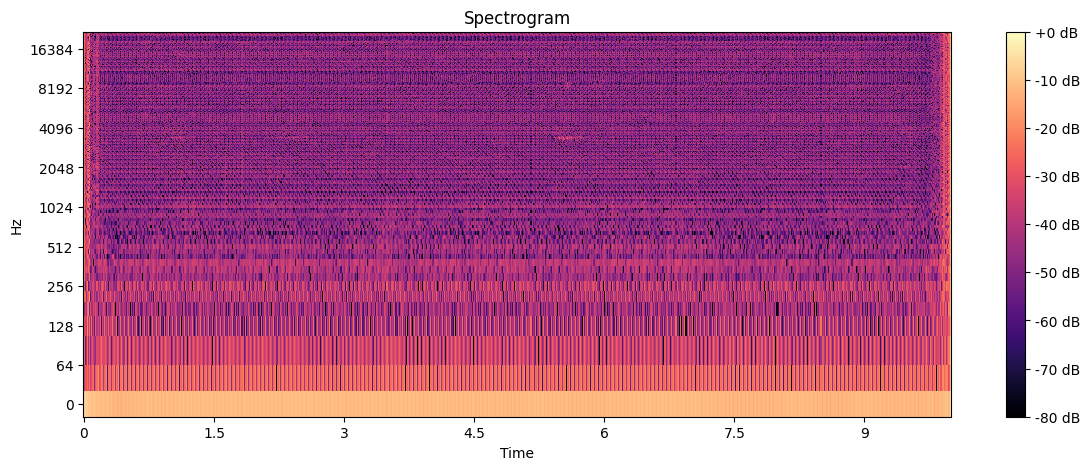

In [22]:
import numpy as np
import soundfile as sf

importlib.reload(cvae_actual_i_think) # Reload the cvae module to ensure it's up to date

label = np.array([1])
z = np.random.rand(1,model.model.latent_size) * 2 - 1

print(torch.from_numpy(z).float())
print(torch.from_numpy(label))

# device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
# print(device)
print(model.device)
z = torch.from_numpy(z).float().to(model.device)
labels = torch.tensor(label).to(model.device)

generated_images = model.model.sample(z, labels)

D_real = generated_images[0][0].cpu().detach().numpy()
D_imag = generated_images[0][1].cpu().detach().numpy()

D_real_mean = -0.00022800823861055075
D_real_std = 3.1135954811248605
D_imag_mean = -2.303626924950437e-08
D_imag_std = 2.8981973344661305

# rescale to original size
D_real = (D_real * (D_real_std + 1e-8) * 16) + D_real_mean
D_imag = (D_imag * (D_imag_std + 1e-8) * 16) + D_imag_mean
# D_real = ((D_real + 1) / 2) * (D_max - D_min + 1e-8) + D_min
# D_imag = ((D_imag + 1) / 2) * (D_max - D_min + 1e-8) + D_min

D = D_real + 1j * D_imag

print(D.shape)
# plot the spectrogram using librosa
import matplotlib.pyplot as plt
sr = 44100
plt.figure(figsize=(14, 5))
librosa.display.specshow(librosa.amplitude_to_db(D_real, ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()



# convert to audio
y = librosa.core.istft(D, hop_length=512, win_length=1024, window='hann')

# save audio
sf.write('sample.mp3', y, sr)

# play the audio
import IPython.display as ipd
ipd.Audio(y, rate= sr)